# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt

import torch.nn as nn
import pandas as pd
import os

from tokenization.word_tokenizer import WordTokenizer
from trainer.trainer import Trainer
from model.bilstm import BiLSTM

In [88]:
MAX_VOCAB_SIZE  = 20_000
MAX_LEN         = 256
SEED            = 42
EPOCHS          = 10
BATCH_SIZE      = 128
LEARNING_RATE   = 1e-4

# Load Data and preprocess data

In [89]:
train_data = load_dataset('imdb', split="train[10:85%]")
eval_data = load_dataset('imdb', split="train[:10%]+train[85%:]")
test_data = load_dataset('imdb', split="test")

In [90]:
tokenizer = WordTokenizer(train_data['text'], MAX_VOCAB_SIZE, MAX_LEN)

# Train

In [96]:
configs = [
    {
        'learning_rate': 1e-4,
        'embedding_dim': 300,
        'rnn_size': 256,
        'hidden_size': 256,
        'dropout': 0.5,
    }
]

In [97]:
for config in configs:
    lr = config['learning_rate']
    ed = config['embedding_dim']
    rs = config['rnn_size']
    hs = config['hidden_size']
    do = config['dropout']

    run_name = f'lr{lr}-em{ed}-rnn{rs}-hidden{hs}-do{do}-vocab{MAX_VOCAB_SIZE}-len{MAX_LEN}'.replace(".", "_")

    model = BiLSTM(
        vocab_size      = MAX_VOCAB_SIZE,
        embedding_dim   = ed,
        rnn_size        = rs,
        hidden_size     = hs,
        dropout         = do,
        padding_index   = tokenizer.get_pad_token()
    )

    criterion = nn.BCELoss()
    trainer = Trainer(
        model,
        tokenizer,
        criterion,
        train_data,
        eval_data,
        num_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        run_name=run_name,
        early_stop=False,
        learning_rate=lr
    )

    trainer.train()

Validation: 100%|██████████| 6250/6250 [00:51<00:00, 120.30it/s]


# Test and Plot Results

In [3]:
def draw_axes(ax, data, title, metric_columns, labels):
    ax.set_title(title)

    ax.plot(data['epoch'], data[metric_columns[0]], label=labels[0])
    ax.plot(data['epoch'], data[metric_columns[1]], label=labels[1], linestyle='dashed')

    ax.set_xlabel('Epoch')
    ax.set_ylabel(title)
    ax.legend()
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y')

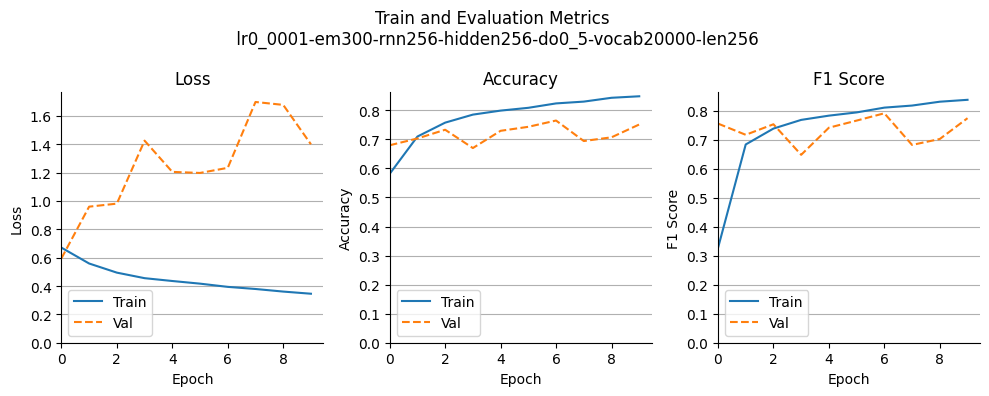

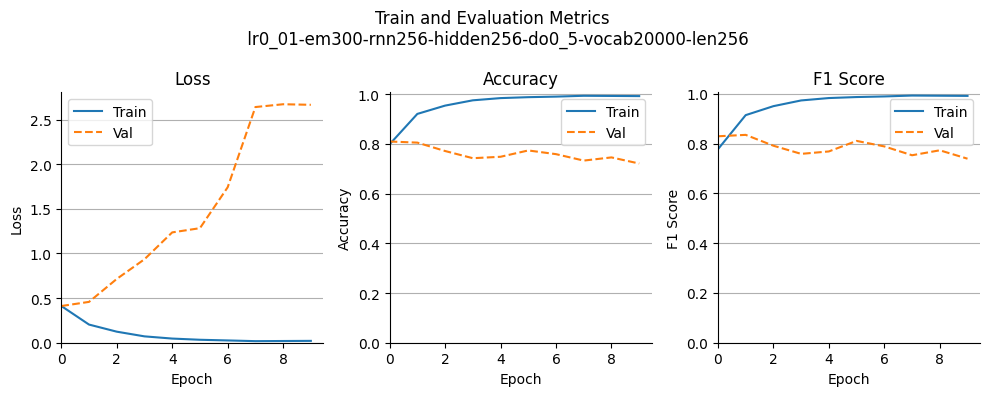

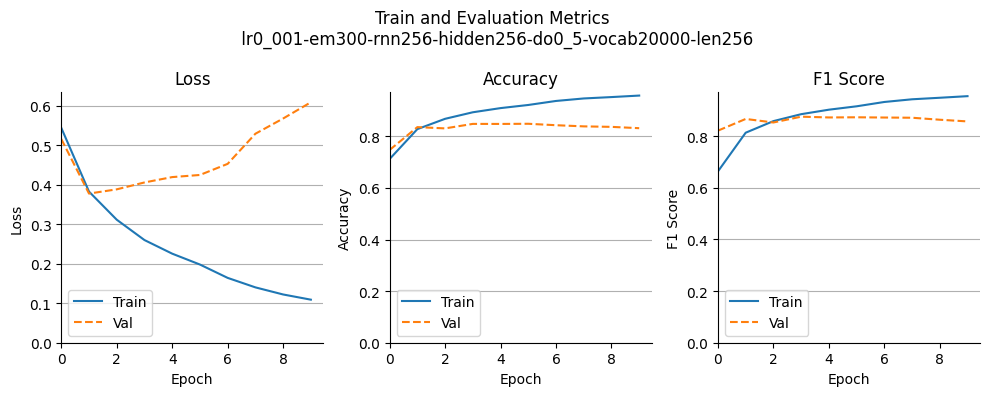

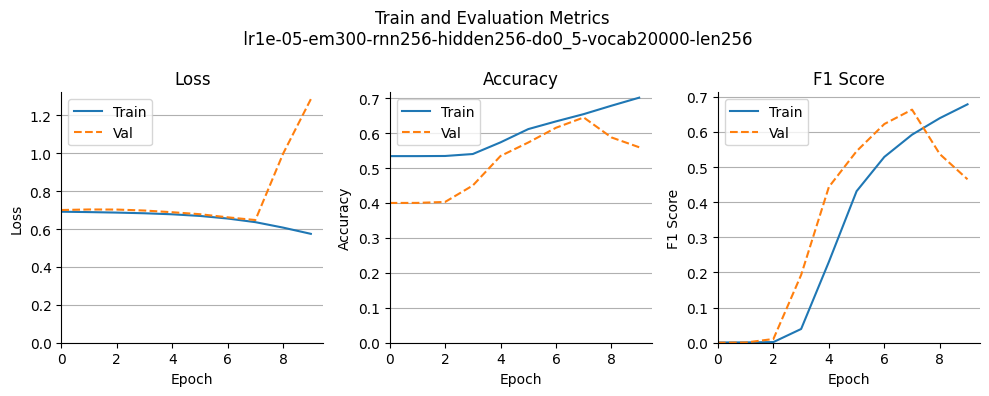

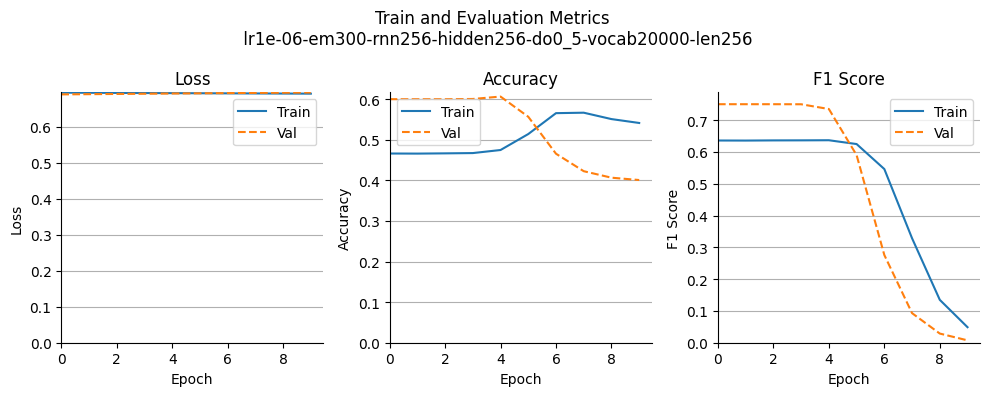

In [4]:
for directory in os.listdir('out/'):
    metrics = pd.read_csv(f'out/{directory}/metrics/metrics.csv')

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    fig.suptitle(f'Train and Evaluation Metrics \n {directory}')

    draw_axes(axes[0], metrics, 'Loss', ['train_loss', 'val_loss'], ['Train', 'Val'])
    draw_axes(axes[1], metrics, 'Accuracy', ['train_accuracy', 'val_accuracy'], ['Train', 'Val'])
    draw_axes(axes[2], metrics, 'F1 Score', ['train_f1', 'val_f1'], ['Train', 'Val'])

    plt.tight_layout()